# Logistic Regression, Gradient Descent

This notebook will show a few things.

* HOWTO simulate data for testing logistic regression
* HOWTO solve a logistic regression problem using [Autograd](https://github.com/HIPS/autograd).

## Simulate data

Here, we simulate data according to the following equation.

$\log \frac{p}{1-p} = 1.0 + 2.0 * x_1 + 3.0 * x_2$

It's easier to understand the simulation if we rewrite the equation to look like the following.

$p = \frac{ 1 }{ 1 + \mathrm{e}^{1.0 + 2.0 * x_1 + 3.0 * x_2}}$

Note that the values $x_1$ and $x_2$ are sampled from a Gaussian distribution.

* $X_1 \sim \mathcal{N}(0, 1)$
* $X_2 \sim \mathcal{N}(0, 1)$

The value $p$ that we get is the plugged into the [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) to sample our output labels of 1's and 0's.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import binomial, normal
from scipy.stats import bernoulli, binom

np.random.seed(37)
sns.set(color_codes=True)

n = 10000
X = np.hstack([
    np.array([1 for _ in range(n)]).reshape(n, 1), 
    normal(0.0, 1.0, n).reshape(n, 1), 
    normal(0.0, 1.0, n).reshape(n, 1)
])
z = np.dot(X, np.array([1.0, 2.0, 3.0])) + normal(0.0, 1.0, n)
p = 1.0 / (1.0 + np.exp(-z))
y = binom.rvs(1, p)

## Visualize data

Here's a plot of the positive (the one's or red dots) and negative (the zero's or green dots) examples.

Text(0, 0.5, '$x_1$')

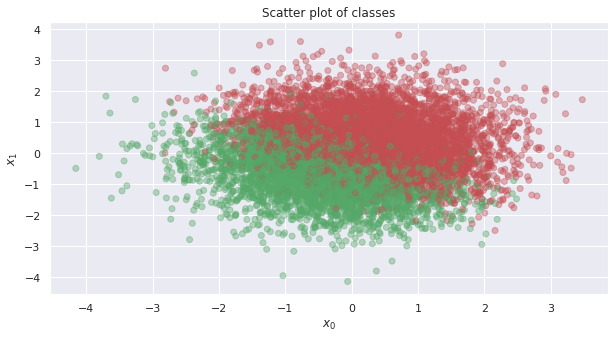

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=False, sharey=False)

colors = ['r' if 1 == v else 'g' for v in y]
ax.scatter(X[:, 1], X[:, 2], c=colors, alpha=0.4)
ax.set_title('Scatter plot of classes')
ax.set_xlabel(r'$x_0$')
ax.set_ylabel(r'$x_1$')

This plot is the density over the `score` $Xw$ (the data $X$ dot the weights $w$).

Text(0, 0.5, 'probability')

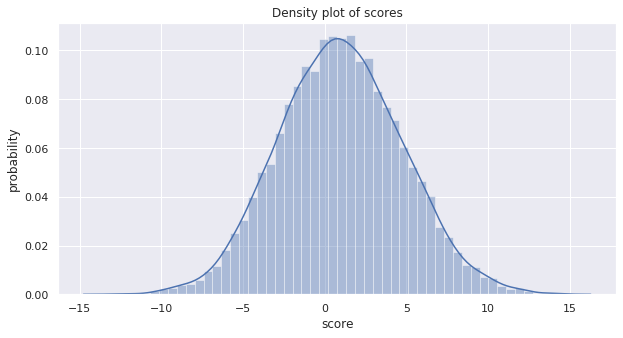

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=False, sharey=False)

sns.distplot(z, ax=ax)
ax.set_title('Density plot of scores')
ax.set_xlabel(r'score')
ax.set_ylabel(r'probability')

These next two plots are of the density of the probabilities (note how they center around 0 and 1) and a bar chart of the frequency of the classes.

Text(0, 0.5, 'count')

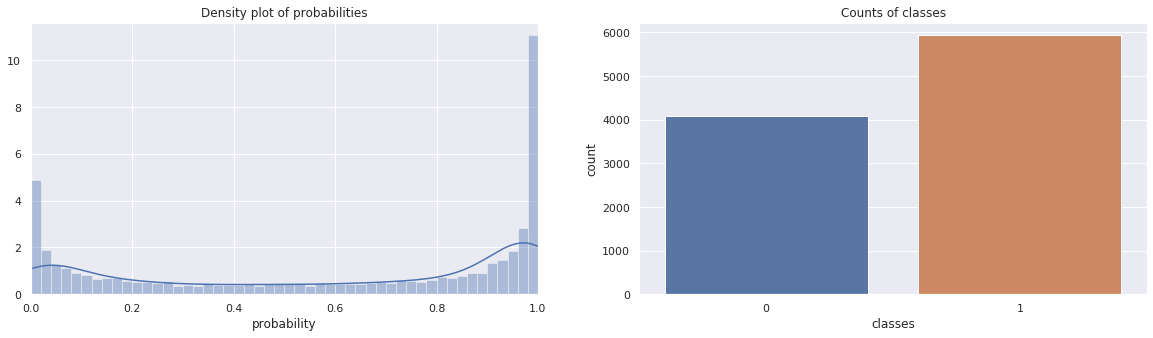

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5), sharex=False, sharey=False)

sns.distplot(p, bins=50, ax=ax[0])
ax[0].set_title('Density plot of probabilities')
ax[0].set_xlabel(r'probability')
ax[0].set_xlim([0, 1])

sns.countplot(y, ax=ax[1])
ax[1].set_title('Counts of classes')
ax[1].set_xlabel(r'classes')
ax[1].set_ylabel(r'count')

## Use gradient descent through Autograd to learn the weights

Now we use Autograd to help learn the coefficients of the logistic model through gradient descent. Note that the loss function is defined as follows.

$\frac{1}{n} \sum -(\hat{y}_i - y_i) + \log (1 + \mathrm{e}^{\hat{y}_i})$

* $\hat{y}_i$ is the i-th predicted probability
* $y_i$ is the i-th class label (0 or 1)

Using Autograd, we do not have to specify (or code up) the gradients of this loss function. We will run the gradient descent algorithm to learn the weights of the logistic regression model using different learning rates, $\alpha$ e.g. 0.01, 0.05, 0.1, 1.0.

In [5]:
import autograd.numpy as np
from autograd import grad
from autograd.numpy import exp, log, sqrt

# define the loss function
def loss(w, X, y):
    n = float(len(X))
    y_pred = np.dot(X, w) 
    return np.sum(-(y_pred * y) + log(1.0 + exp(y_pred))) / n

#the magic line that gives you the gradient of the loss function
loss_grad = grad(loss) 

def learn_weights(X, y, alpha=0.05, max_iter=30000, debug=False):
    w = np.array([0.0 for _ in range(X.shape[1])])
    
    if debug is True:
        print('initial weights = {}'.format(w))

    loss_trace = []
    weight_trace = []

    for i in range(max_iter):
        loss = loss_grad(w, X, y)
        w = w - (loss * alpha)
        if i % 2000 == 0 and debug is True:
            print('{}: loss = {}, weights = {}'.format(i, loss, w))

        loss_trace.append(loss)
        weight_trace.append(w)

    if debug is True:
        print('intercept + weights: {}'.format(w))
    
    loss_trace = np.array(loss_trace)
    weight_trace = np.array(weight_trace)
    
    return w, loss_trace, weight_trace

def plot_traces(loss_trace, weight_trace, alpha):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    ax[0].set_title(r'Log-loss of the weights over iterations, $\alpha=${}'.format(alpha))
    ax[0].set_xlabel('iteration')
    ax[0].set_ylabel('log-loss')
    ax[0].plot(loss_trace[:, 0], label=r'$\beta$')
    ax[0].plot(loss_trace[:, 1], label=r'$x_0$')
    ax[0].plot(loss_trace[:, 2], label=r'$x_1$')
    ax[0].legend()

    ax[1].set_title(r'Weight learning over iterations, $\alpha=${}'.format(alpha))
    ax[1].set_xlabel('iteration')
    ax[1].set_ylabel('weight')
    ax[1].plot(weight_trace[:, 0], label=r'$\beta$')
    ax[1].plot(weight_trace[:, 1], label=r'$x_0$')
    ax[1].plot(weight_trace[:, 2], label=r'$x_1$')
    ax[1].legend()

The important thing to note here is that the learning rate impacts how quickly we converge to the estimated coefficients. For smaller learning rates, it takes longer to find the optimal solution (weights). For the running example, $\alpha=0.01$ takes over 8,000 iterations to reach the optimal solution. Be careful, however, as $\alpha$ will need to be fined tune so that the solution can converge. 

We plot the traces of the loss over the number of iterations as well as the change in the coefficients over the number of iterations.

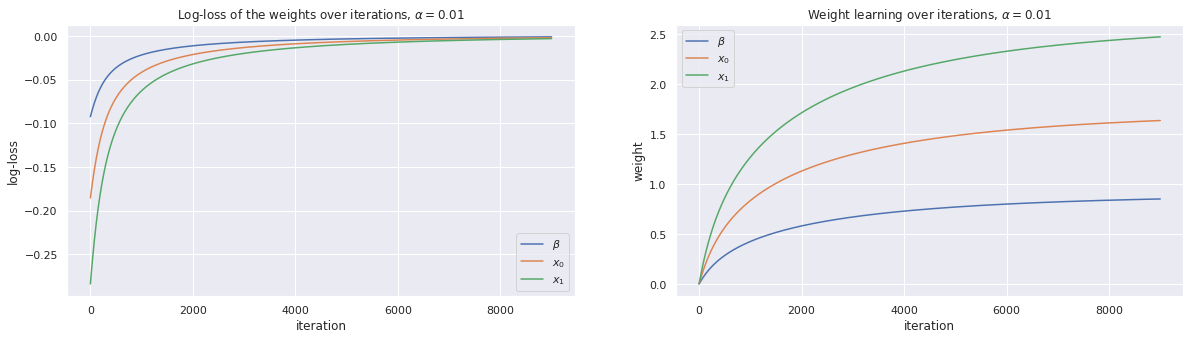

In [6]:
w, loss_trace, weight_trace = learn_weights(X, y, alpha=0.01, max_iter=9000)
plot_traces(loss_trace, weight_trace, alpha=0.01)

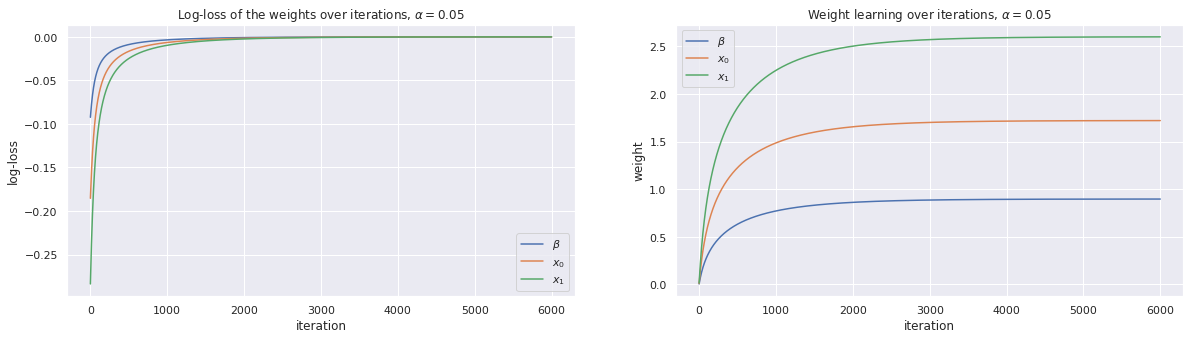

In [7]:
w, loss_trace, weight_trace = learn_weights(X, y, alpha=0.05, max_iter=6000)
plot_traces(loss_trace, weight_trace, alpha=0.05)

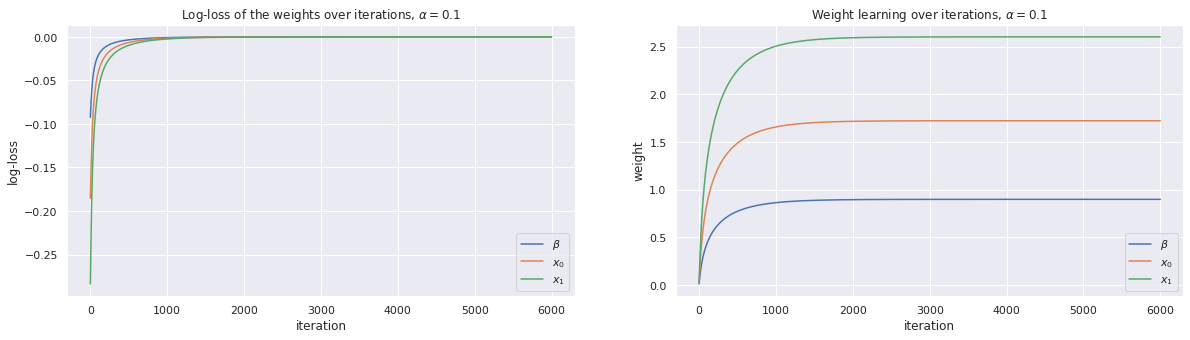

In [8]:
w, loss_trace, weight_trace = learn_weights(X, y, alpha=0.1, max_iter=6000)
plot_traces(loss_trace, weight_trace, alpha=0.1)

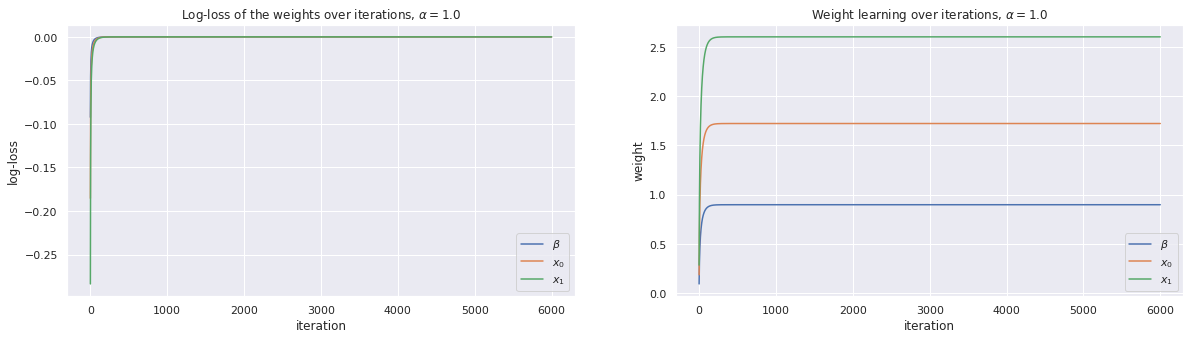

In [9]:
w, loss_trace, weight_trace = learn_weights(X, y, alpha=1.0, max_iter=6000)
plot_traces(loss_trace, weight_trace, alpha=1.0)

## Verify the results with scikit-learn

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(fit_intercept=False, solver='lbfgs')
lr.fit(X, y)

print(lr.coef_)

[[0.89312519 1.71445566 2.59091944]]
